In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

In [17]:
# Load CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize pixels to [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print("Training shape:", x_train.shape)
print("Testing shape:", x_test.shape)

Training shape: (50000, 32, 32, 3)
Testing shape: (10000, 32, 32, 3)


In [18]:
def build_optimized_conv_autoencoder(latent_dim=128):
    # Encoder
    input_img = Input(shape=(32, 32, 3))
    x = Conv2D(64, (3,3), strides=1, padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3,3), strides=2, padding='same')(x)   # downsample to 16x16
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3,3), strides=2, padding='same')(x)   # downsample to 8x8
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(latent_dim, (3,3), strides=1, padding='same')(x)   # latent space 8x8xlatent_dim
    encoded = Activation('relu')(x)

    # Decoder
    x = Conv2DTranspose(latent_dim, (3,3), strides=1, padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, (3,3), strides=2, padding='same')(x)  # upsample to 16x16
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(128, (3,3), strides=2, padding='same')(x)  # upsample to 32x32
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    decoded = Conv2DTranspose(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')  # can replace mse with SSIM loss for sharper output
    return autoencoder


In [19]:
latent_dim = 128  # try 64 or 128 for sharper output
autoencoder = build_optimized_conv_autoencoder(latent_dim)

history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test, x_test))


Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - loss: 0.0127 - val_loss: 0.0102
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 9.8784e-04 - val_loss: 0.0019
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 8.7073e-04 - val_loss: 0.0011
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 8.2454e-04 - val_loss: 9.0959e-04
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 6.9591e-04 - val_loss: 0.0011
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 6.1240e-04 - val_loss: 0.0034
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 6.2045e-04 - val_loss: 7.9812e-04
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 6.1462e-04 - val_loss: 7.7399e-04
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 5.2696e-04 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


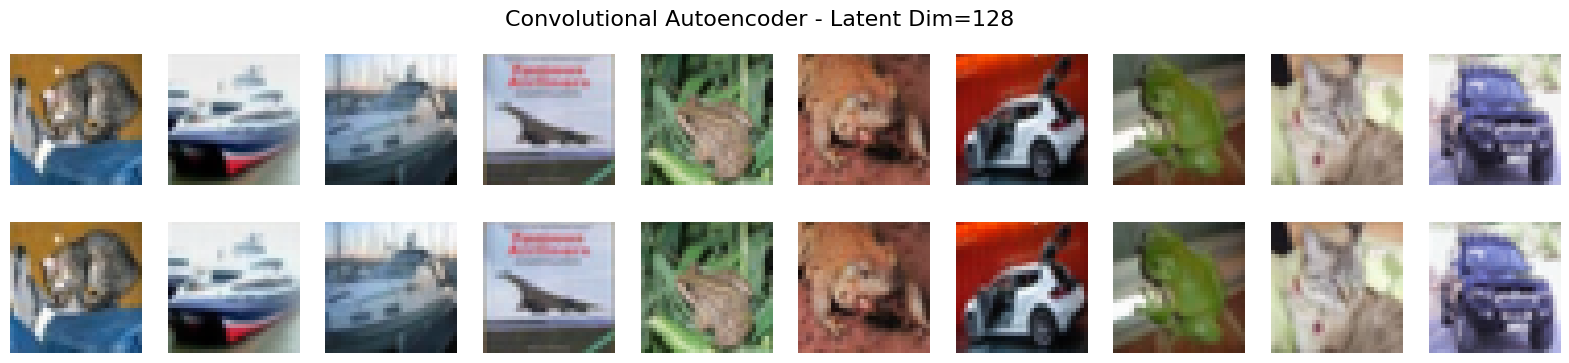

In [20]:
# Reconstruct first 10 test images
decoded_imgs = autoencoder.predict(x_test[:10])

plt.figure(figsize=(20,4))
for i in range(10):
    # Original
    ax = plt.subplot(2,10,i+1)
    plt.imshow(x_test[i])
    plt.axis('off')

    # Reconstructed
    ax = plt.subplot(2,10,i+11)
    plt.imshow(decoded_imgs[i])
    plt.axis('off')

plt.suptitle(f"Convolutional Autoencoder - Latent Dim={latent_dim}", fontsize=16)
plt.show()
